# Microsoft Malware Competition

The malware industry continues to be a well-organized, well-funded market dedicated to evading traditional security measures. Once a computer is infected by malware, criminals can hurt consumers and enterprises in many ways.

With more than one billion enterprise and consumer customers, Microsoft takes this problem very seriously and is deeply invested in improving security.

https://www.kaggle.com/c/microsoft-malware-prediction


### Goal: FInd the Malware!

This is a tabular competition and my first jump back into a Kaggle competition for 8 days of fury.
The Microsoft Malware Loader needs to run before this one is. 

### Challenges
Overall this seems like a time series problem without time series. Additionally, the large amount of data makes it difficult to properly load. Even with 8 gig of memory I ran into issues loading everything. 

Also there are large differences between train, public and private datasets.

### Lessons Learned
1. Memory management takes a large amount of effort. Reducing memory size, like int64 to bool, drastically cut down on usage.
2. Feature extraction is very important as well. Some of my ideas didn't pan out and made the model much worse. 
3. Categorical vs. Floatlist- For a long time I was using Floatlist, however that wasn't the correct metric to be using. Finally, I figured out how the correct values to submit with predictions. 

### Best Discussions to look at
https://www.kaggle.com/c/microsoft-malware-prediction/discussion/84112
https://www.kaggle.com/c/microsoft-malware-prediction/discussion/84069

In [1]:
import pickle
from fastai import *
from fastai.tabular import *
from fastai.metrics import error_rate
import gc

#Selecting the right GPU
torch.cuda.set_device(1)

# A dataframe can make 
pd.options.display.max_rows = 20
pd.options.display.max_columns = 10

## Load all the pickles!

In [2]:
# I love pickles!
# These are all made from the dataloader
path = Path('/home/jd/data/microsoft')
df=pickle.load(open( "/home/jd/data/microsoft/microsoft-df-save.p", "rb" ) )
cat_names=pickle.load(open( "/home/jd/data/microsoft/microsoft-cat-save.p", "rb" ) )
cont_names = pickle.load(open( "/home/jd/data/microsoft/microsoft-cont-save.p", "rb" ) )
test_df = pickle.load(open( "/home/jd/data/microsoft/microsoft-test.p", "rb" ) )
valid_idx = pickle.load(open( "/home/jd/data/microsoft/valid_idx", "rb" ) )

## Last Data manipulation

In [3]:
# Smaller subset if needed and for testing. 
df=df[:500000]

In [4]:
df[:5]

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,...,DateCensus_OSVersionMonth,DateCensus_OSVersionWeek,DateCensus_OSVersionDay,DateCensus_OSVersionDayofweek,DaysElapsedCensus_OSVersion
0,0000028988387b115f69f31a3bf04f09,2,67,65,2004,...,7,27,9,2,36
1,000007535c3f730efa9ea0b7ef1bd645,2,57,30,626,...,4,16,18,5,61
2,000007905a28d863f6d0d597892cd692,2,67,65,1875,...,7,27,9,2,36
3,00000b11598a75ea8ba1beea8459149f,2,67,65,1926,...,8,32,13,2,24
4,000014a5f00daa18e76b81417eeb99fc,2,67,65,1885,...,7,29,22,2,33


In [5]:
# The dataframe is looking for Has Detections
# We want the following processing as well
dep_var = 'HasDetections'
procs = [FillMissing, Categorify, Normalize]

## Auc_Score
Had a difficult time implementing

In [6]:
#data.show_batch(rows=10)
from sklearn.metrics import roc_auc_score

def auc_score1(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1]))

## Start the testing!

In [7]:
# Test data is stored here.
test = TabularList.from_df(test_df, path=path, cat_names=cat_names,cont_names=cont_names)

In [8]:
# This took a long time to figure out including.
# 1. Categorylist or Floatlist- Floatlist gave me better values for awhile
# 2. Validation Splits. Since there was a though of a time component I broke these apart elsewhere
# 3. This is also where I got the most errors around no-memory

data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(valid_pct=0.1, seed=42)
                           #.split_by_idx(valid_idx)
                           .label_from_df(cols=dep_var, label_cls=CategoryList)
                           .add_test(test)
                           .databunch(bs=2048))


In [9]:
# I am still confused a bit around y-range. Not sure why its a tensor, or if it really matters that we put the numbers in.
# it did not impact scores. Even when range was set at None.
y_range = torch.tensor([-.2, 1.2], device=defaults.device)

# Also lots of tweaking involved. Overall, there seemed to be a problem with overfitting, and playing with 
# layers didn't seem to change much
# 1. Trying to understand how the layers 
# 2. ps is dropout for the first and 2nd layer. Doesn't matter cause neither are trained
# 3. embedding drop out- Left the same as the rossmann example
# 4. I tried limiting embedding size to save on memory and prevent overfit. It seemed like they were exploding.
# 5. Mtrics- allowed the auc-score
learn = tabular_learner(data, layers=[1000,500], 
                        ps=[0.1,0.1], 
                        emb_drop=0.04, 
                        y_range=None,
                        #emb_szs={"CityIdentifier": 150, 
                        #       "Census_OEMModelIdentifier": 150, 
                        #       "Census_InternalBatteryNumberOfCharges": 150,
                        #       "Census_FirmwareVersionIdentifier": 150}
                        metrics=auc_score1
                        )

In [10]:
#learn.summary()

### Learning, fitting and loading

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


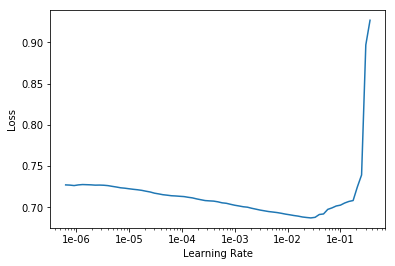

In [11]:
# See plot
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(4, 1e-02, wd=0.1)
learn.save('Mar11')

epoch,train_loss,valid_loss,auc_score1,time
0,0.638937,0.633311,0.686131,00:22
1,0.616267,0.642940,0.693807,00:21
2,0.543362,0.683351,0.670464,00:22
3,0.398916,0.884862,0.645095,00:22


In [ ]:
learn.fit_one_cycle(4, 1e-02, wd=0.1)
learn.save('Mar11-2')

In [ ]:
learn.fit_one_cycle(4, 1e-02, wd=0.1)
learn.save('Mar11-3')

In [ ]:
learn.fit_one_cycle(5, 1e-03, wd=0.3)
learn.save('Mar11-4')

## Data Validation
There isn't much validation other than looking at predictions vs targets to see if they are calculated correctly.

In [ ]:
learn.load('Mar11')

In [13]:
preds,targs = learn.get_preds()

In [14]:
preds[:20]

tensor([[0.7127, 0.2873],
        [0.1388, 0.8612],
        [0.6648, 0.3352],
        [0.0634, 0.9366],
        [0.6278, 0.3722],
        [0.6553, 0.3447],
        [0.9635, 0.0365],
        [0.1389, 0.8611],
        [0.5627, 0.4373],
        [0.5228, 0.4772],
        [0.2904, 0.7096],
        [0.4027, 0.5973],
        [0.7129, 0.2871],
        [0.2374, 0.7626],
        [0.8032, 0.1968],
        [0.1521, 0.8479],
        [0.6498, 0.3502],
        [0.4036, 0.5964],
        [0.6149, 0.3851],
        [0.3503, 0.6497]])

In [15]:
targs[:20]

tensor([0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0])

## Submission

In [16]:
# load weight I want
#learn.load('Mar7')

In [17]:
# Test code Ids
test_ID_codes_df = test_df.pop('MachineIdentifier')

In [18]:
# See the top 5 so that they make sense
test_ID_codes_df[:5]

0    0000010489e3af074adeac69c53e555e
1    00000176ac758d54827acd545b6315a5
2    0000019dcefc128c2d4387c1273dae1d
3    0000055553dc51b1295785415f1a224d
4    00000574cefffeca83ec8adf9285b2bf
Name: MachineIdentifier, dtype: category
Categories (7853253, object): [0000010489e3af074adeac69c53e555e, 00000176ac758d54827acd545b6315a5, 0000019dcefc128c2d4387c1273dae1d, 0000055553dc51b1295785415f1a224d, ..., fffff90b27a1248b6fffc7a535bd736c, fffffa6a956c17ddbabca53d4ab708ae, fffffad7b6c8196ec5cae634406c0d4f, fffffbd305a90eb0f93ee4f30a39c736]

In [19]:
#preds = learn.get_preds(ds_type=DatasetType.Test)
preds = learn.get_preds(ds_type=DatasetType.Test)

In [20]:
### preds[0][:,0]  !!!This is the wrong one!!
# Show predictions, so they make sense
preds[0][:,1]

tensor([0.2129, 0.5857, 0.5574,  ..., 0.5864, 0.0747, 0.0643])

In [21]:
# setup just predictions
target_preds = preds[0][:,1]

In [22]:
# ensure test data_df has both
test_df['MachineIdentifier'] = test_ID_codes_df
test_df['HasDetections'] = target_preds

In [23]:
# Look at the min and max values here. 
test_df['HasDetections'].min(), test_df['HasDetections'].max()

(3.5165624e-16, 1.0)

In [24]:
# Also just want to see if this makes sense
test_df['HasDetections'].agg(['min', 'max', 'mean', 'std']).round(decimals=2)

min     0.00
max     1.00
mean    0.48
std     0.28
Name: HasDetections, dtype: float64

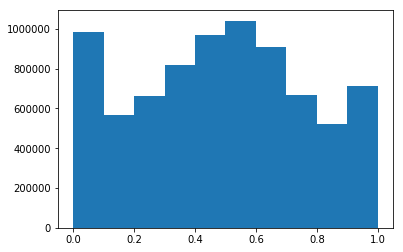

In [25]:
# Draw a quick graph for distribution.
# lots more training would have a saddle instead of a bump
import numpy as np
import matplotlib.pyplot as plt
mu, sigma = 200, 25
x = test_df['HasDetections']
n, bins, patches = plt.hist(x)
plt.show()

In [26]:
# Submit for running!
test_df.to_csv('/home/jd/data/microsoft/submit/submission.csv', columns=['MachineIdentifier', 'HasDetections'], index=False)
print("http://localhost:8888/view/data/microsoft/submit/submission.csv")

http://localhost:8888/view/data/microsoft/submit/submission.csv
